# Query and Stack Imagery into a GIF Using stackstac and Dask

**Attribution**: This tutorial is developed based on the [example](https://stackstac.readthedocs.io/en/latest/examples/gif.html) provided in the stackstac documentation. 

We'll load all the [Landsat-8 (Collection 2, Level 2)](https://planetarycomputer.microsoft.com/dataset/landsat-8-c2-l2) data that's available from [Microsoft's Planetary Computer](https://planetarycomputer.microsoft.com/) over a small region on the coast of [Cape Cod](https://www.google.com/maps/place/Chatham,+MA/@41.7498076,-70.2026227,10.73z/data=!4m13!1m7!3m6!1s0x89fb15440149e94d:0x1f9c0efa001cb20b!2sCape+Cod!3b1!8m2!3d41.6687897!4d-70.2962408!3m4!1s0x89fb142168afbe53:0x714436ec7d485a53!8m2!3d41.6821432!4d-69.9597359), Massachusetts, USA.

Using nothing but standard xarray syntax, we'll mask cloudy pixels with the Landsat QA band and reduce the data down to biannual median composites. We will use Dask to make this much faster. 

[Animated](https://geogif.readthedocs.io/en/latest/) as a GIF, we can watch the coastline move over the years due to [longshore drift](https://en.wikipedia.org/wiki/Longshore_drift).

In [1]:
import dask
import pystac_client
import planetary_computer as pc
import leafmap
import geogif
import stackstac

Start your Dask cluster:

In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

<Client: 'tcp://127.0.0.1:34759' processes=4 threads=8, memory=32.00 GiB>

Interactively pick the area of interest from a map. Just move the map around and re-run all cells to generate the timeseries somewhere else!

In [3]:
import leafmap

In [4]:
m = leafmap.Map(center=[41.64933994767867, -69.94438630063088], zoom=12, height="800px")
m

Map(center=[41.64933994767867, -69.94438630063088], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [5]:
bbox = (m.west, m.south, m.east, m.north)

## Search for STAC items

Use [pystac-client](https://github.com/stac-utils/pystac-client) to connect to Microsoft's STAC API endpoint and search for Landsat-8 scenes.

In [6]:
catalog = pystac_client.Client.open('https://planetarycomputer.microsoft.com/api/stac/v1')

search = catalog.search(
    collections=['landsat-8-c2-l2'],
    bbox=bbox,
)

Load and sign all the STAC items with a token from Planetary Computer. Without this, loading the data will fail.

In [7]:
%%time
items = pc.sign(search)
len(items)

CPU times: user 791 ms, sys: 58.9 ms, total: 850 ms
Wall time: 1.76 s


226

These are the footprints of all the items we'll use:

In [8]:
m.add_geojson(items.to_dict())
m

Map(bottom=391020.0, center=[41.64933994767867, -69.94438630063088], controls=(ZoomControl(options=['position'…

## Create an xarray with stacksatc

Set `bounds_latlon=bbox` to automatically clip to our area of interest (instead of using the full footprints of the scenes).

In [9]:
%%time
stack = stackstac.stack(items, bounds_latlon=bbox)
stack

CPU times: user 332 ms, sys: 8.36 ms, total: 341 ms
Wall time: 332 ms


<xarray.DataArray 'stackstac-ea6e31b1fb957cbf001558f247a72100' (time: 226,
                                                                band: 19,
                                                                y: 770, x: 912)>
dask.array<fetch_raster_window, shape=(226, 19, 770, 912), dtype=float64, chunksize=(1, 1, 770, 912), chunktype=numpy.ndarray>
Coordinates: (12/27)
  * time                         (time) datetime64[ns] 2013-03-22T15:19:00.54...
    id                           (time) <U31 'LC08_L2SP_011031_20130322_02_T1...
  * band                         (band) <U13 'SR_B1' 'SR_B2' ... 'SR_QA_AEROSOL'
  * x                            (x) float64 4.077e+05 4.077e+05 ... 4.35e+05
  * y                            (y) float64 4.623e+06 4.623e+06 ... 4.6e+06
    view:off_nadir               int64 0
    ...                           ...
    title                        (band) <U46 'Coastal/Aerosol Band (B1)' ... ...
    gsd                          (band) float64 30.0 30.0 30.0 ... 30.0 30.0
    common_name                  (band) object 'coastal' 'blue' ... None None
    center_wavelength            (band) object 0.44 0.48 0.56 ... None None None
    full_width_half_max          (band) object 0.02 0.06 0.06 ... None None None
    epsg                         int64 32619
Attributes:
    spec:        RasterSpec(epsg=32619, bounds=(407670.0, 4599720.0, 435030.0...
    crs:         epsg:32619
    transform:   | 30.00, 0.00, 407670.00|\n| 0.00,-30.00, 4622820.00|\n| 0.0...
    resolution:  30.0

And that's it for stackstac! Everything from here on is just standard xarray operations.

In [10]:
# Band names are not trivial from the initial query
stack.band

<xarray.DataArray 'band' (band: 19)>
array(['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'ST_QA',
       'ST_B10', 'ST_DRAD', 'ST_EMIS', 'ST_EMSD', 'ST_TRAD', 'ST_URAD',
       'QA_PIXEL', 'ST_ATRAN', 'ST_CDIST', 'QA_RADSAT', 'SR_QA_AEROSOL'],
      dtype='<U13')
Coordinates: (12/16)
  * band                       (band) <U13 'SR_B1' 'SR_B2' ... 'SR_QA_AEROSOL'
    view:off_nadir             int64 0
    proj:epsg                  int64 32619
    landsat:processing_level   <U4 'L2SP'
    landsat:wrs_row            <U3 '031'
    instruments                object {'oli', 'tirs'}
    ...                         ...
    title                      (band) <U46 'Coastal/Aerosol Band (B1)' ... 'A...
    gsd                        (band) float64 30.0 30.0 30.0 ... 30.0 30.0 30.0
    common_name                (band) object 'coastal' 'blue' ... None None
    center_wavelength          (band) object 0.44 0.48 0.56 ... None None None
    full_width_half_max        (band) object 0.02 0.06 0.06 ... None None None
    epsg                       int64 32619

In [11]:
# Use common_name for bands
stack = stack.assign_coords(band=stack.common_name.fillna(stack.band).rename("band"))
stack.band

<xarray.DataArray 'band' (band: 19)>
array(['coastal', 'blue', 'green', 'red', 'nir08', 'swir16', 'swir22', 'ST_QA',
       'lwir11', 'ST_DRAD', 'ST_EMIS', 'ST_EMSD', 'ST_TRAD', 'ST_URAD',
       'QA_PIXEL', 'ST_ATRAN', 'ST_CDIST', 'QA_RADSAT', 'SR_QA_AEROSOL'],
      dtype=object)
Coordinates: (12/16)
  * band                       (band) object 'coastal' ... 'SR_QA_AEROSOL'
    view:off_nadir             int64 0
    proj:epsg                  int64 32619
    landsat:processing_level   <U4 'L2SP'
    landsat:wrs_row            <U3 '031'
    instruments                object {'oli', 'tirs'}
    ...                         ...
    title                      (band) <U46 'Coastal/Aerosol Band (B1)' ... 'A...
    gsd                        (band) float64 30.0 30.0 30.0 ... 30.0 30.0 30.0
    common_name                (band) object 'coastal' 'blue' ... None None
    center_wavelength          (band) object 0.44 0.48 0.56 ... None None None
    full_width_half_max        (band) object 0.02 0.06 0.06 ... None None None
    epsg                       int64 32619

See how much input data there is for just RGB. This is the amount of data we'll end up processing

In [12]:
stack.sel(band=["red", "green", "blue"])

<xarray.DataArray 'stackstac-ea6e31b1fb957cbf001558f247a72100' (time: 226,
                                                                band: 3,
                                                                y: 770, x: 912)>
dask.array<getitem, shape=(226, 3, 770, 912), dtype=float64, chunksize=(1, 1, 770, 912), chunktype=numpy.ndarray>
Coordinates: (12/27)
  * time                         (time) datetime64[ns] 2013-03-22T15:19:00.54...
    id                           (time) <U31 'LC08_L2SP_011031_20130322_02_T1...
  * band                         (band) object 'red' 'green' 'blue'
  * x                            (x) float64 4.077e+05 4.077e+05 ... 4.35e+05
  * y                            (y) float64 4.623e+06 4.623e+06 ... 4.6e+06
    view:off_nadir               int64 0
    ...                           ...
    title                        (band) <U46 'Red Band (B4)' ... 'Blue Band (...
    gsd                          (band) float64 30.0 30.0 30.0
    common_name                  (band) object 'red' 'green' 'blue'
    center_wavelength            (band) object 0.65 0.56 0.48
    full_width_half_max          (band) object 0.04 0.06 0.06
    epsg                         int64 32619
Attributes:
    spec:        RasterSpec(epsg=32619, bounds=(407670.0, 4599720.0, 435030.0...
    crs:         epsg:32619
    transform:   | 30.00, 0.00, 407670.00|\n| 0.00,-30.00, 4622820.00|\n| 0.0...
    resolution:  30.0

## Mask cloudy pixels using the QA band

Use the bit values of the Landsat-8 QA band to mask out bad pixels. We'll mask pixels labeled as dilated cloud, cirrus, cloud, or cloud shadow. (By "mask", we mean just replacing those pixels with NaNs).

See page 14 on [this PDF](https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/media/files/LSDS-1619_Landsat-8-9-C2-L2-ScienceProductGuide-v4.pdf) for the data table describing which bit means what.

In [13]:
# Make a bitmask---when we bitwise-and it with the data, it leaves just the 4 bits we care about
mask_bitfields = [1, 2, 3, 4]  # dilated cloud, cirrus, cloud, cloud shadow
bitmask = 0
for field in mask_bitfields:
    bitmask |= 1 << field

bin(bitmask)

'0b11110'

In [14]:
qa = stack.sel(band="QA_PIXEL").astype("uint16")
bad = qa & bitmask  # just look at those 4 bits

good = stack.where(bad == 0)  # mask pixels where any one of those bits are set

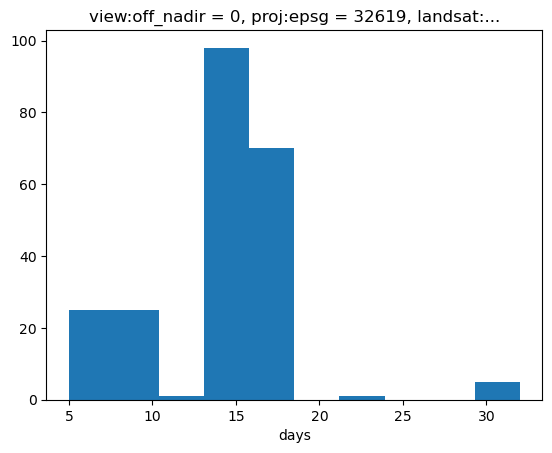

In [15]:
# What's the typical interval between scenes?
good.time.diff("time").dt.days.plot.hist();

## Make biannual median composites

The Landsat-8 scenes appear to typically be 5-15 days apart. Let's composite that down to a 6-month interval.

Since the cloudy pixels we masked with NaNs will be ignored in the `median`, this should give us a decent cloud-free-ish image for each.

In [16]:
# Make biannual median composites (`2Q` means 2 quarters)
composites = good.resample(time="2Q").median("time")
composites

<xarray.DataArray 'stackstac-ea6e31b1fb957cbf001558f247a72100' (time: 19,
                                                                band: 19,
                                                                y: 770, x: 912)>
dask.array<stack, shape=(19, 19, 770, 912), dtype=float64, chunksize=(1, 1, 770, 912), chunktype=numpy.ndarray>
Coordinates: (12/13)
  * band                       (band) object 'coastal' ... 'SR_QA_AEROSOL'
  * x                          (x) float64 4.077e+05 4.077e+05 ... 4.35e+05
  * y                          (y) float64 4.623e+06 4.623e+06 ... 4.6e+06
    view:off_nadir             int64 0
    proj:epsg                  int64 32619
    landsat:processing_level   <U4 'L2SP'
    ...                         ...
    instruments                object {'oli', 'tirs'}
    landsat:wrs_type           <U1 '2'
    landsat:collection_number  <U2 '02'
    platform                   <U9 'landsat-8'
    epsg                       int64 32619
  * time                       (time) datetime64[ns] 2013-03-31 ... 2022-03-31
Attributes:
    spec:        RasterSpec(epsg=32619, bounds=(407670.0, 4599720.0, 435030.0...
    crs:         epsg:32619
    transform:   | 30.00, 0.00, 407670.00|\n| 0.00,-30.00, 4622820.00|\n| 0.0...
    resolution:  30.0

Pick the red-green-blue bands to make a true-color image.

In [17]:
rgb = composites.sel(band=["red", "green", "blue"])
rgb

<xarray.DataArray 'stackstac-ea6e31b1fb957cbf001558f247a72100' (time: 19,
                                                                band: 3,
                                                                y: 770, x: 912)>
dask.array<getitem, shape=(19, 3, 770, 912), dtype=float64, chunksize=(1, 1, 770, 912), chunktype=numpy.ndarray>
Coordinates: (12/13)
  * band                       (band) object 'red' 'green' 'blue'
  * x                          (x) float64 4.077e+05 4.077e+05 ... 4.35e+05
  * y                          (y) float64 4.623e+06 4.623e+06 ... 4.6e+06
    view:off_nadir             int64 0
    proj:epsg                  int64 32619
    landsat:processing_level   <U4 'L2SP'
    ...                         ...
    instruments                object {'oli', 'tirs'}
    landsat:wrs_type           <U1 '2'
    landsat:collection_number  <U2 '02'
    platform                   <U9 'landsat-8'
    epsg                       int64 32619
  * time                       (time) datetime64[ns] 2013-03-31 ... 2022-03-31
Attributes:
    spec:        RasterSpec(epsg=32619, bounds=(407670.0, 4599720.0, 435030.0...
    crs:         epsg:32619
    transform:   | 30.00, 0.00, 407670.00|\n| 0.00,-30.00, 4622820.00|\n| 0.0...
    resolution:  30.0

Some final cleanup to make a nicer-looking animation:

* Forward-fill any NaN pixels from the previous frame, to make the animation look less jumpy.
* Also skip the first frame, since its NaNs can't be filled from anywhere.

In [18]:
cleaned = rgb.ffill("time")[1:]

## Render the GIF

Use [GeoGIF](https://geogif.readthedocs.io/en/latest/) to turn the stack into an animation. We'll use [dgif](https://geogif.readthedocs.io/en/latest/api.html#dask-dgif) to render the GIF on the cluster, so there's less data to send back. (GIFs are a lot smaller than NumPy arrays!)

In [ ]:
%%time
gif_img = geogif.dgif(cleaned).compute()

In [20]:
# we turned ~3.5GiB of data into a 4MB GIF!
dask.utils.format_bytes(len(gif_img.data))

'3.34 MiB'

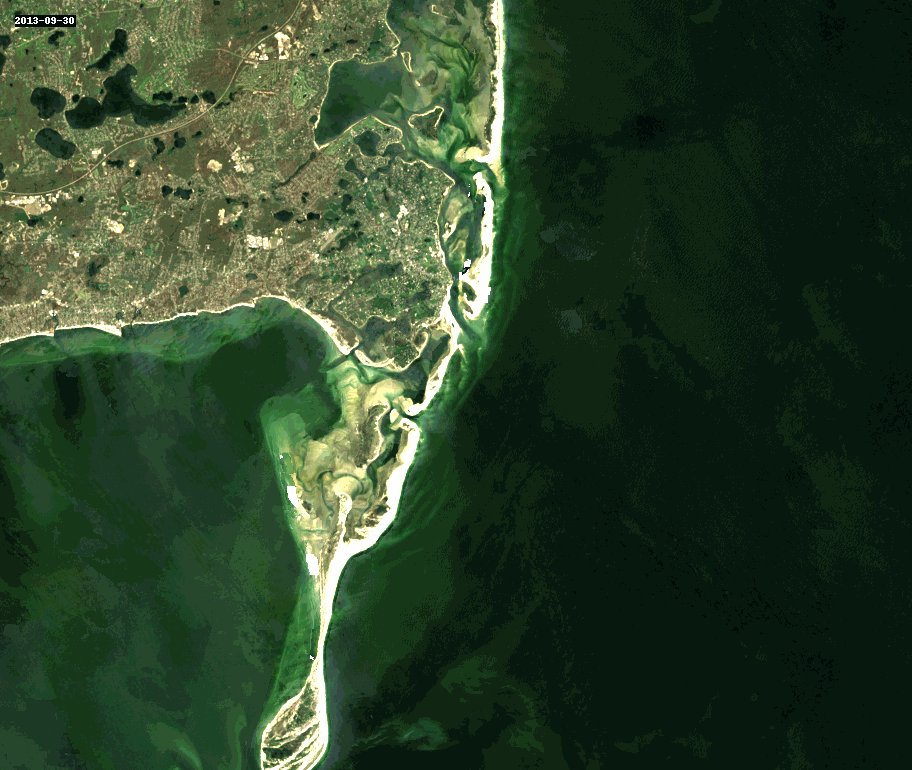

In [21]:
gif_img